## Week 4: Afternoon session - Clustering and regression with correlated high dimension data

This noteook has two main exercises:

* Apply k-means to find clusters in the synthetic drilling data and the Octane dataset.  If you wish to you can try doing this in the original high dimension dataset, but this will fail.  Instead try use the first few principal components that you've found in the example datasets.

* Train a linear regression model (least squares or robust, and using either Seaborn or scikit-learn - try them all if you'd like to!) on the drilling or Octane datasets.  You cannot use the datasets at their full dimension because there are less observations than there are features (in the original feature space)!  But you'll likely find that you train a model based on the PC-transformed features.  Use the code from the last two sessions to do this.  You can start simple - Try to predict quartz based on the first PC, try the same with Octane.  Then build on this as you become more confident and ambitious! 

Also, see if you can find out how to use scikit-learn pipelines to implement this as a pipeline with a transform, followed by a linear regression.  You may find the week 3 afternoon session useful to review.

This afternoon session also has one worked example:

* Apply training, test and validation to our old friend the metal recovery model.

### K-means clustering in scikit-learn

The k-means algorithm searches for clusters in an unlabelled multidimensional (the of low dimension) dataset.  If you're dataset is high dimension that you'll need to reduce the dimension, using, for example, principal components.

It does this through a simple, but sometimes effective, formulation of what good clustering is.  It believes that the centre of a cluster should be the mean average of all of the points belonging to the cluster, and it believes that each point should be closer to its own cluster's centre than to any other.  This has many of the characteristics (and flaws) of the linear models we've been looking at over the last couple of weeks.  That said, it's often worth trying before more sophisticated approaches.

You can also easily find information on how to use k-means in scikit-learn through internet searches, but lets use a textbook example, then try applying this to another dataset.

Explore the other objects and methods in sklearn.cluster.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                      cluster_std=0.60, random_state=0)

In [2]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
# Have a look at y_kmeans.  It has assigned a cluster number
# to each observation.

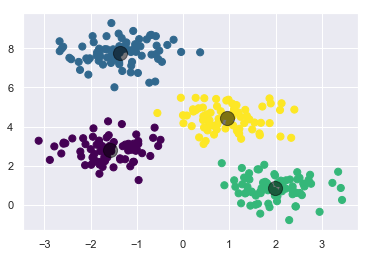

In [3]:
plt.scatter(X[:, 0], X[:,1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

Now try this with some of the clusters that we observed this morning.

Firstly, let's try this with the synthetic drilling data, after transformation with PC1 and PC2.

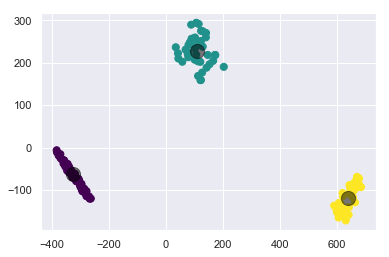

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from week4_help import create_composition_dataframe, create_observations, create_templates_matrix

# Create the templates as per the morning
templates = create_templates_matrix()
# Create 150 sets of ground truth assays
compositions = create_composition_dataframe(150)
# Use the templates and ground truth to create synthetic observations
observations = create_observations(compositions, templates)
# Transpose them to put observations into tidy data format
transposed_observations = observations.transpose()

pca = PCA(n_components=5)
pca.fit(transposed_observations)
# the transformed features are often referred to as scores in the
# context of PCA
scores = pca.transform(transposed_observations)
clustering_model = KMeans(n_clusters=3)
X = scores[:, [0,1]]
clustering_model.fit(X)
cluster_labels = clustering_model.predict(X)
plt.scatter(X[:,0], X[:,1], c=cluster_labels, s=50, cmap='viridis')
cluster_centres = clustering_model.cluster_centers_
plt.scatter(cluster_centres[:, 0], cluster_centres[:, 1], c='black', s=200, alpha=0.5);


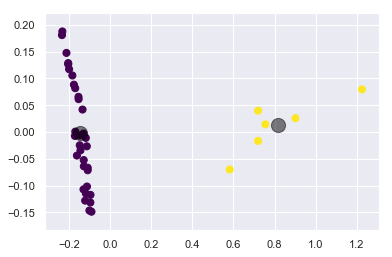

In [5]:
# Let's try the same with Octane
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

octane_dataframe = pd.read_excel('octane.xlsx')
# save Octane number because we're going to use it for regression in the next
# activity
octane_assays = octane_dataframe['Octane number']

octane_dataframe = \
    octane_dataframe.drop(columns=['Sample name', 'Octane number'])
observations = octane_dataframe.values
pca = PCA(n_components=15)
pca.fit(observations)
scores = pca.transform(observations)

clustering_model = KMeans(n_clusters=2)
X = scores[:, [0,1]]
clustering_model.fit(X)
cluster_labels = clustering_model.predict(X)
plt.scatter(X[:,0], X[:,1], c=cluster_labels, s=50, cmap='viridis')
cluster_centres = clustering_model.cluster_centers_
plt.scatter(cluster_centres[:, 0], cluster_centres[:, 1], c='black', s=200, alpha=0.5);

This is similar to what we did in the morning, but kmeans has semi-automatically found the inlier and outlier groups in Octane.  This is reasonable as is, if we knew beforehand that observations are likely to be in one of two groups.

In [6]:
# Lets use the cluster labels to split the observations
# into inliers and outliers.  We could use
# clustering_model.predict to classify new observations
# into the inlier or outlier groups.  If we're making
# a regression model then we could choose to report
# a gross deviation from normal operation if the
# new observation is assigned to the outlier group
# and we could make an octane prediction if it fits
# into the inlier group.

inlier_indices = np.where((cluster_labels == 0))[0]
outlier_indices = np.where ((cluster_labels == 1))[0]
inliers = observations[inlier_indices]
outliers = observations[outlier_indices]

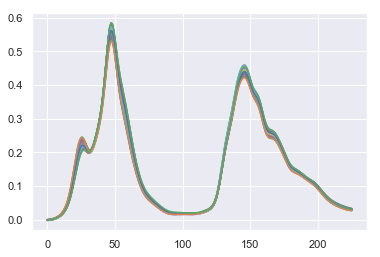

In [7]:
# How do the inliers look?
fig, ax = plt.subplots(1,1)
for idx in inlier_indices:
    plt.plot(observations[idx])

### Principal Components Regression:

This is something you can fully implement with what you already know.  First find the principal components and create a linear regression model that predicts octane based using the principal component scores as the features.  Plot predicted octane against assay octane and look at the R^2 and the residuals.

This is a real industrial application.  There is a an expensive and slow analytical process for measuring the octane rating of petrol, but it's not useful for production, where it's desirable that we have continuous and cheap online monitoring of octane rating as hydrocarbons are blended together.  To achieve this infrared spectroscopy is used and a model is constructed that relates octane rating to the observed spectra.  Once the model is created and validated it is used to predict octane rating continuously and cheaply.

By using principal components we can make a predictive model with hundreds of observed variables and only ~30 observations.  This is impossible with linear least squares.

In [8]:
# Let's try to find a linear model that relates octane rating to the principal
# components of the spectra.  We'll take out the outliers first.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

def get_octane_observations_and_assays(inlier_indices):
    octane_dataframe = pd.read_excel('octane.xlsx')
    octane_assays = octane_dataframe['Octane number'][inlier_indices]

    octane_dataframe = \
        octane_dataframe.drop(columns=['Sample name', 'Octane number'])
    observations = octane_dataframe.values[inlier_indices]
    return observations, octane_assays

def build_model(number_of_components):
    observations, assays = get_octane_observations_and_assays(inlier_indices)
    pca = PCA(n_components=number_of_components)
    pca.fit(observations)
    scores = pca.transform(observations)

    model = LinearRegression(fit_intercept=True)
    features_matrix = scores[:,:]
    target_array = assays
    model.fit(features_matrix, target_array)
    print('Model R^2 is ',model.score(features_matrix, target_array))
    predicted_octane = model.predict(features_matrix)
    plt.scatter(assays, predicted_octane)
    
    plt.xlabel('Octane Rating Assay')
    plt.ylabel('Octane Rating Predicted')

Model R^2 is  0.7519080989910976


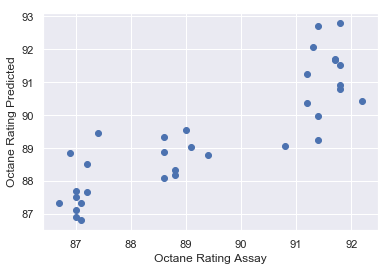

In [9]:
# The parameter 1 specifies that we're building a model using just the first principal component.  This is what we get
# if we try to find a univariate linear relationship between the first principal component scores and octane rating.
build_model(1)

Based on just PC1 there is an approximate linear relationship, but it looks like there is unmodelled non-gaussian error present.  The relationship may be improved by including additional PCs.  We'll also look at the predicted vs actual plot for octane.

Model R^2 is  0.9797636204100756


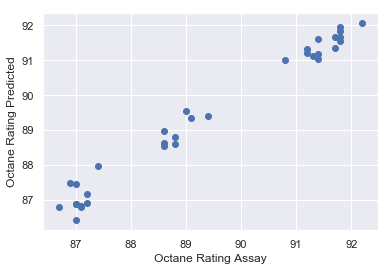

In [10]:
build_model(2)

Model R^2 is  0.9830061930270494


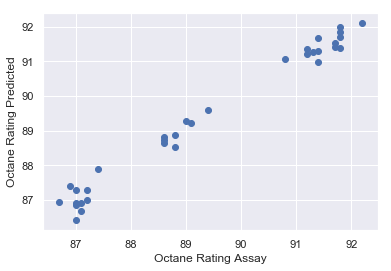

In [11]:
# Will the predictions improve if we consider 4 principal components?
build_model(4)

Model R^2 is  0.9987879424006759


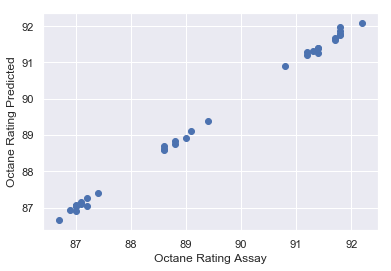

In [12]:
# What if we include 25 principal components?
build_model(25)

When we use 25 components we have a very tight fit, but we are likely overfitting the model to the training data that we have.  We need a way to choose the optimium number of components to use such that we're not overfitting the model, but we still have good predictive power.  We saw this demonstrated in the logistic regression model of week 3.  Let's look at it in the context of fitting a general linear model (in this case with the "parts" made of polynomial terms) to a function similar to the metal recovery vs sulphur data.

### Model validation revisited

Let's use cross validation to fit a polynomial model to the metal recovery dataset.  This is analogous to hyperparameter selection that will be used for other scikit-learn models.

In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                        LinearRegression(**kwargs))

In [14]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1)**2
    y = 10 - 1.0 / (X.ravel()+0.1)
    if err > 0:
        y+= err * rng.randn(N)
    return X, y

X, y = make_data(50)

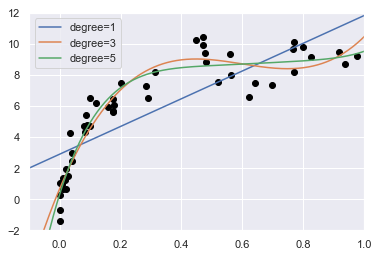

In [15]:
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color = 'black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

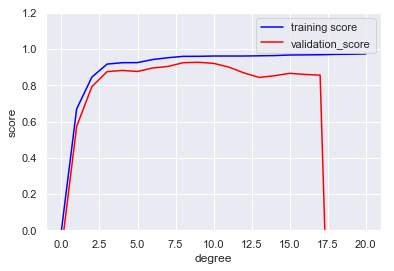

In [16]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y, 
                                         'polynomialfeatures__degree',
                                         degree, cv=7)
plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation_score')
plt.legend(loc='best')
plt.ylim(0, 1.2)
plt.xlabel('degree')
plt.ylabel('score');

### Learning Curves

The optimal model will usually depend on how much training data you have.  Learning curves are a tool to identify when a model will be improved by more data, or whether it's already about as good as it will get (though a different kind of model may still work better).

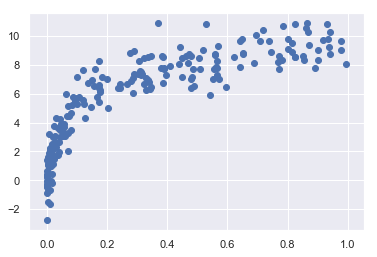

In [17]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

(0, 1)

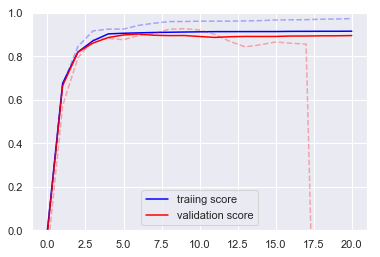

In [18]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree',
                                            degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue',
        label='traiing score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3,
         linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3,
        linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)

Learning Curves behave like this:

* A model of a given complexity will overfit a small dataset: this means the training score will be relatively high, while the validation score will be relatively low.

* A model of a given complexity will underfit a large dataset: this means that the training score will decrease, but the validation score will increase.

* A model will never, except by chance or a mistake in your code, give a better score to the validation set then the training set: this means the curves should keep getting closer together, but never cross.

* This all implies that if a model is being overfitted, then the behaviour may improve if you increase the size of the training set.  This is a reason why neural network models, with their high complexity, require lots of training data to behave well.  Conversely, when the training and validation curves have converged then you don't need to spend time, energy or money collecting more data (unless you intend to bring in a higher complexity model in future).


### Building a cross-validated Principal Component Regression (PCR) model

Lets apply this to the principal components model that we've been developing, which looks promising but may be overfitting if we choose to include too many components.  Unfortunately PCR isn't built in to scikit-learn so creating the learning curve like above is complicated, but we'll return to it when we try more complex models, that also happen to be built-in in future.

We can apply cross-validation to to PCR however, and see how cross validated scores vary with the number of components.

In [19]:
def build_modelXy(X, y, number_of_components):
    pca = PCA(n_components=number_of_components)
    pca.fit(X)
    scores = pca.transform(X)
    model = LinearRegression(fit_intercept=True)
    features_matrix = scores[:,:]
    target_array = y
    model.fit(features_matrix, target_array)
    predicted_octane = model.predict(features_matrix)
    return model.score(features_matrix, target_array)

In [20]:
# Not cross-validated.  Note that the error only gets better as we increase
# the number of components.
observations, assays = get_octane_observations_and_assays(inlier_indices)
build_modelXy(observations, assays, 1)

0.7519080989910976

In [21]:
build_modelXy(observations, assays, 2)

0.9797636204100756

In [22]:
build_modelXy(observations, assays, 15)

0.9966212072954055

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import validation_curve
from sklearn.cross_validation import cross_val_score

def get_octane_observations_and_assays(inlier_indices):
    octane_dataframe = pd.read_excel('octane.xlsx')
    octane_assays = octane_dataframe['Octane number'][inlier_indices]

    octane_dataframe = \
        octane_dataframe.drop(columns=['Sample name', 'Octane number'])
    observations = octane_dataframe.values[inlier_indices]
    return observations, octane_assays
    
X, y = get_octane_observations_and_assays(inlier_indices)

regression = LinearRegression(fit_intercept=True)
components_to_test = np.arange(1,25)
component_scores = []
for components_to_test in range(1, 32):
    pca = PCA(n_components=components_to_test)
    pipe = Pipeline(steps=[('pca', pca), ('regression', regression)])
    component_scores.append(cross_val_score(estimator=pipe,
                                           X=X, y=y).mean())

C:\Users\fra256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


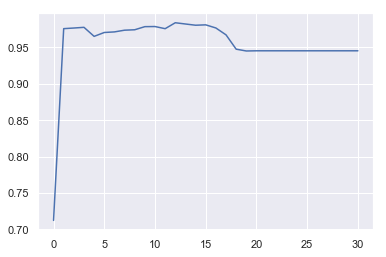

In [24]:
plt.plot(component_scores)

The relationship between error in prediction of octane rating and the number of components isn't simple.  This is partly because principal components aims to answer the question of how best to explain as much variance as possible in the X data in as few components as possible.  This is not the same question as how to find the fewest components that can best predict octane rating.  The latter question is closer to what PLS tries to answer.  This will be explored further soon.

The plot above suggests that a good model PCR may be found with four components (being where the first local minimum appears, and because there is little substantial improvement in R^2 after that), and that additional components may be overfitting.